In [116]:
from neurkal import popcode

from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [117]:
sns.set_style("whitegrid")

In [183]:
reload(popcode)

<module 'neurkal.popcode' from '/home/mll/dev/neural-kalman/neurkal/popcode.py'>

In [41]:
def sensory_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(x - x_i) - 1)) + 0.01)

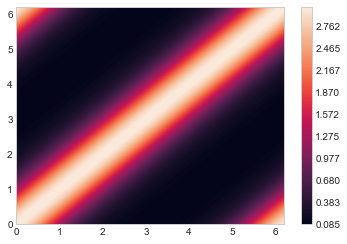

In [95]:
# visualize activation function for sensory input layer
act = np.vectorize(sensory_act)
x = np.arange(0, 2 * np.pi, 0.1)
z = act(*np.meshgrid(x, x))
levels = np.linspace(np.min(z), np.max(z), 100)
act_cf = plt.contourf(x, x, z, levels=levels)
plt.colorbar(act_cf)
plt.show()

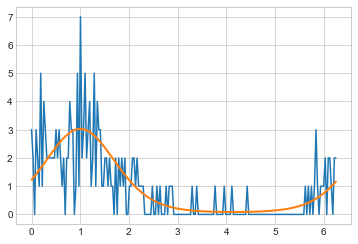

In [131]:
# sensory input layer example activation
sensory_code = popcode.PopCode(shape=200, act_func=sensory_act, dist=np.random.poisson)
activity = sensory_code(2*np.pi + 1)
plt.plot(sensory_code.prefs[0], activity)
plt.plot(sensory_code.prefs[0], sensory_code.mean_activity, lw=2)
plt.show()

In [185]:
# example basis network, for experiments
sensory_codes = [popcode.PopCode(shape=4, act_func=sensory_act, dist=np.random.poisson),
                popcode.PopCode(shape=7, act_func=sensory_act, dist=np.random.poisson)]
basis = popcode.BasisNetwork(sensory_codes)